### Data Preprocessing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import warnings
warnings.filterwarnings(action='ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


In [2]:
dir_path = '/kaggle/input/porto-seguro-safe-driver-prediction'
train = pd.read_csv(f'{dir_path}/train.csv')
test = pd.read_csv(f'{dir_path}/test.csv')

In [3]:
print(f'train.shape : {train.shape}')
print(f'test.shape : {test.shape}')

train.shape : (595212, 59)
test.shape : (892816, 58)


In [4]:
target_feature = list(set(train.columns) - set(test.columns))
target_feature

['target']

In [5]:
def df_dtypes(df):
    pd.set_option('display.max_colwidth', None)

    df_dtypes = df.columns.groupby(df.dtypes)
    df_dtypes = pd.DataFrame({
        'dtype': list(df_dtypes.keys()),
        '# columns': [len(df_dtypes[key]) for key in df_dtypes.keys()],
        'columns': [list(df_dtypes[key]) for key in df_dtypes.keys()]
    })
    df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])
    return df_dtypes

In [6]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,49,"['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']"
1,float64,10,"['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']"


In [7]:
def compute_dtype(df):
    return list(df.dtypes.astype(str))
def compute_count(df):
    return [round(df[col].mean(), 1) for col in df.columns]
def compute_mean(df, features):
    return [round(df[col].mean(), 1) if col in features else '' for col in df.columns]
def compute_std(df, features):
    return [round(df[col].std(), 1) if col in features else '' for col in df.columns]
def compute_min(df, features):
    return [round(df[col].min(), 1) if col in features else '' for col in df.columns]
def compute_max(df, features):
    return [round(df[col].max(), 1) if col in features else '' for col in df.columns]
def compute_quantile(df, features, percentage):
    return [round(df[col].quantile(percentage), 1) if col in features else '' for col in df.columns]
def compute_IQR(df, features):
    return [round(df[col].max() - df[col].min(), 1) if col in features else '' for col in df.columns]
def compute_nunique(df):
    return [df[col].nunique() for col in df.columns]
def compute_unique(df, threshold):
    return [df[col].unique() if df[col].nunique() < threshold else '' for col in df.columns]
def compute_mode(df):
    return [df[col].mode()[0] if len(df[col].mode()) else '' for col in df.columns]
def compute_mode_count(df):
    return [df[col].value_counts().max for col in df.columns]
def compute_mode_percentage(df):
    return [round(df[col].value_counts().max() * 100 / df.shape[0], 1) for col in df.columns]
def compute_null_count(df):
    return [df[col].isnull().sum() for col in df.columns]
def compute_null_percentage(df):
    return [round(df[col].isnull().mean() * 100, 1) for col in df.columns]
    

In [8]:
def build_my_info_table(df, nunique_threshold=30):
    numerical_features = df.select_dtypes(include=[np.number])
    df_info = pd.DataFrame({
        '#':        np.arange(len(df.columns)),
        'column':   df.columns,
        'dtype':    compute_dtype(df),
        'count':    compute_count(df),
        'mean':     compute_mean(df, numerical_features),
        'std':      compute_std(df, numerical_features),
        'min':      compute_min(df, numerical_features),
        '25%':      compute_quantile(df, numerical_features, .25),
        '50%':      compute_quantile(df, numerical_features, .5),
        '75%':      compute_quantile(df, numerical_features, .75),
        'max':      compute_max(df, numerical_features),
        'IQR':      compute_IQR(df, numerical_features),
        'nunique':  compute_nunique(df),
        'unique':   compute_unique(df, nunique_threshold),
        'mode':     compute_mode(df),
        'mode #':   compute_mode_count(df),
        'mode %':   compute_mode_percentage(df),
        'null #':   compute_null_count(df),
        'null %':   compute_null_percentage(df),
    })
    df_info = df_info.sort_values(by='dtype')
    return df_info

In [9]:
build_my_info_table(train)

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
35,35,ps_car_12,float64,0.4,0.4,0.1,-1.0,0.3,0.4,0.4,1.3,2.3,184,,0.316228,"<bound method Series.max of ps_car_12\n0.316228 170579\n0.400000 111873\n0.374166 98598\n0.447214 49318\n0.424264 49293\n ... \n0.282843 1\n0.465188 1\n0.699428 1\n0.465296 1\n0.705195 1\nName: count, Length: 184, dtype: int64>",28.7,0,0.0
36,36,ps_car_13,float64,0.8,0.8,0.2,0.3,0.7,0.8,0.9,3.7,3.5,70482,,0.674583,"<bound method Series.max of ps_car_13\n0.674583 386\n0.741689 377\n0.692776 363\n0.841781 362\n0.749228 353\n ... \n1.666391 1\n1.190640 1\n0.668268 1\n0.731630 1\n1.561918 1\nName: count, Length: 70482, dtype: int64>",0.1,0,0.0
37,37,ps_car_14,float64,0.3,0.3,0.4,-1.0,0.3,0.4,0.4,0.6,1.6,850,,-1.000000,"<bound method Series.max of ps_car_14\n-1.000000 42620\n 0.361525 17696\n 0.358329 15523\n 0.361939 11885\n 0.368782 11626\n ... \n 0.526783 1\n 0.213073 1\n 0.603324 1\n 0.411461 1\n 0.511371 1\nName: count, Length: 850, dtype: int64>",7.2,0,0.0
22,22,ps_reg_03,float64,0.6,0.6,0.8,-1.0,0.5,0.7,1.0,4.0,5.0,5013,,-1.000000,"<bound method Series.max of ps_reg_03\n-1.000000 107772\n 0.633936 664\n 0.602599 637\n 0.704894 627\n 0.587899 616\n ... \n 1.397990 1\n 0.215058 1\n 1.620764 1\n 1.967073 1\n 1.743560 1\nName: count, Length: 5013, dtype: int64>",18.1,0,0.0
21,21,ps_reg_02,float64,0.4,0.4,0.4,0.0,0.2,0.3,0.6,1.8,1.8,19,"[0.2, 0.4, 0.0, 0.6, 1.8, 0.1, 0.7, 1.4, 0.9, 0.3, 0.5, 0.8, 1.0, 1.3, 1.6, 1.5, 1.2, 1.1, 1.7]",0.200000,"<bound method Series.max of ps_reg_02\n0.2 114886\n0.3 95033\n0.0 89297\n0.4 59746\n0.5 36528\n0.6 33474\n0.1 31816\n0.7 21210\n0.8 19907\n0.9 16788\n1.2 15843\n1.0 12570\n1.3 11761\n1.1 11321\n1.4 6877\n1.5 5845\n1.6 5095\n1.8 4737\n1.7 2478\nName: count, dtype: int64>",19.3,0,0.0
20,20,ps_reg_01,float64,0.6,0.6,0.3,0.0,0.4,0.7,0.9,0.9,0.9,10,"[0.7, 0.8, 0.0, 0.9, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]",0.900000,"<bound method Series.max of ps_reg_01\n0.9 194608\n0.7 67897\n0.8 60277\n0.6 56243\n0.4 53569\n0.1 43192\n0.3 40290\n0.5 32341\n0.2 25113\n0.0 21682\nName: count, dtype: int64>",32.7,0,0.0
38,38,ps_car_15,float64,3.1,3.1,0.7,0.0,2.8,3.3,3.6,3.7,3.7,15,"[3.6055512755, 2.4494897428, 3.3166247904, 2.0, 3.0, 3.1622776602, 2.8284271247, 3.7416573868, 2.6457513111, 0.0, 1.4142135624, 3.4641016151, 1.7320508076, 2.2360679775, 1.0]",3.605551,"<bound method Series.max of ps_car_15\n3.605551 109765\n3.464102 77200\n3.316625 68737\n3.162278 63323\n3.741657 57757\n2.828427 48680\n3.000000 48537\n2.645751 30388\n2.449490 20445\n2.236068 19397\n0.000000 14186\n2.000000 12830\n1.732051 10744\n1.000000 6708\n1.414214 6515\nName: count, dtype: int64>",18.4,0,0.0
39,39,ps_calc_01,float64,0.4,0.4,0.3,0.0,0.2,0.5,0.7,0.9,0.9,10,"[0.6, 0.3, 0.5, 0.4, 0.7, 0.2, 0.1, 0.9, 0.8, 0.0]",0.600000,"<bound method Series.max of ps_calc_01\n0.6 59837\n0.0 59780\n0.8 59710\n0.5 59612\n0.7 59545\n0.2 59513\n0.1 59504\n0.3 59377\n0.4 59248\n0.9 59086\nName: count, dtype: int64>",10.1,0,0.0
40,40,ps_calc_02,float64,0.4,0.4,0.3,0.0,0.2,0.4,0.7,0.9,0.9,10,"[0.5, 0.1, 0.7, 0.9, 0.6, 0.8, 0.4, 0.0, 0.3, 0.2]",0.500000,"<bound method Series.max of ps_calc_02\n0.5 60070\n0.4 59823\n0.0 59618\n0.3 59593\n0.7 59502\n0.6 59501\n0.2 59385\n0.1 59383\n0.9 59219\n0.8 59118\nName: count, dtype: int64>",10.1,0,0.0
41,41,ps_calc_03,float64,0.4,0.4,0.3,0.0,0.2,0.5,0.7,0.9,0.9,10,"[0.2, 0.3, 0.1, 0.0, 0.4, 0.5, 0.6, 0.8, 0.9, 0.7]",0.100000,"<bound method Series.max of ps_calc_03\n0.1 60036\n0.5 59832\n0.3 59819\n0.6 59521\n0.8 59509\n0.9 59418\n0.7 59393\n0.0 59318\n0.4 59229\n0.2 59137\nName: count, dtype: int64>",10.1,0,0.0


In [10]:
def plot_bar_chart(df, x, y, xlabel, ylabel, title, xmin=None, xmax=None, palette='deep'):
    if df.shape[0] == 0:
        return
    size = (12, df.shape[0] / 4 + 1)
    plt.figure(figsize=size)
    sns.barplot(y=df[y], x=df[x], palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not xmin and not xmax:
        xmin, xmax = df[x].min(), df[x].max()
        xrange = (xmax - xmin) * .1
        xmin, xmax = xmin - xrange, xmax + xrange
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()

In [11]:
train_info = build_my_info_table(train)
nan_df = train_info[train_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature', title='Null Percentage in each Feature', xmin=0, xmax=100, palette='coolwarm')

In [12]:
train = train.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))
test = test.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))

In [13]:
def fillna(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_features:
        df[col] = df[col].fillna(df[col].mode()[0])

def replace_inf(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], np.NaN)
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

In [14]:
replace_inf(train)
replace_inf(test)
fillna(train)
fillna(test)

In [15]:
def get_categorical_features(df, nunique_threshold=30):
    all_df_columns = df.columns
    categorical_features = [col for col in all_df_columns if df[col].nunique() < nunique_threshold]
    return categorical_features

def get_numerical_features(df, nunique_threshold=30):
    numerical_df_columns = df.select_dtypes(include=[np.number]).columns
    numerical_features   = [col for col in numerical_df_columns if df[col].nunique() >= nunique_threshold]
    return numerical_features

In [16]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)
print(f'categorical_features: {len(categorical_features)}\n{categorical_features}\n')
print(f'numerical_features:   {len(numerical_features)}\n{numerical_features}\n')

categorical_features: 53
['target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

numerical_features:   6
['id', 'ps_reg_03', 'ps_car_11_cat', 'ps_car_12', 'ps_car_13', 'ps_car_14']



In [17]:
print(f'train.shape: {train.shape}')
print(f'test.shape : {test.shape}')

train.shape: (595212, 59)
test.shape : (892816, 58)


### Exploratory Data Analysis

In [18]:
# Distribution Plots:
def my_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def my_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def my_kdeplot(df, col, ax):
    sns.kdeplot(f'KDE Plot of {col}')

# Categorical Plots:
def my_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def my_countplot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
def my_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)
def my_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)

# Matrix Plots:
def my_heatmap(df, size, cmap, cbar_kws, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt='.f', cmap=cmap, center=0, cbar_kws=cbar_kws, annot_kws={'size': font_size})
    plt.titel('Correlation Heatmap')
    plt.show()

In [19]:
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1):
    def plot_feature(cols):
        n_plot_funcs = len(plot_funcs)
        fig = plt.figure(figsize=(sum(width_ratios), max(height_ratios)))
        gs = fig.add_gridspec(1, n_plot_funcs * n_col, width_ratios=width_ratios, height_ratios=height_ratios)
        axes = [0] * (n_plot_funcs * n_col)

        for i in range(n_col):
            for j in range(n_plot_funcs):
                k = i * n_plot_funcs + j
                axes[k] = fig.add_subplot(gs[0, k])
                plot_funcs[j](df, cols[i], axes[k])
                axes[k].set_xlabel(cols[i])

        plt.tight_layout()
        plt.show()

    for i in range(0, len(df.columns),n_col):
        plot_feature(df.columns[i:i + n_col])

In [20]:
def plot_numerical_features(df, plot_funcs=[my_boxplot, my_violinplot, my_distplot], width_ratios=[2, 2, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

def plot_categorical_features(df, plot_funcs=[my_pie_chart, my_countplot], width_ratios=[5, 11], height_ratios=[5], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

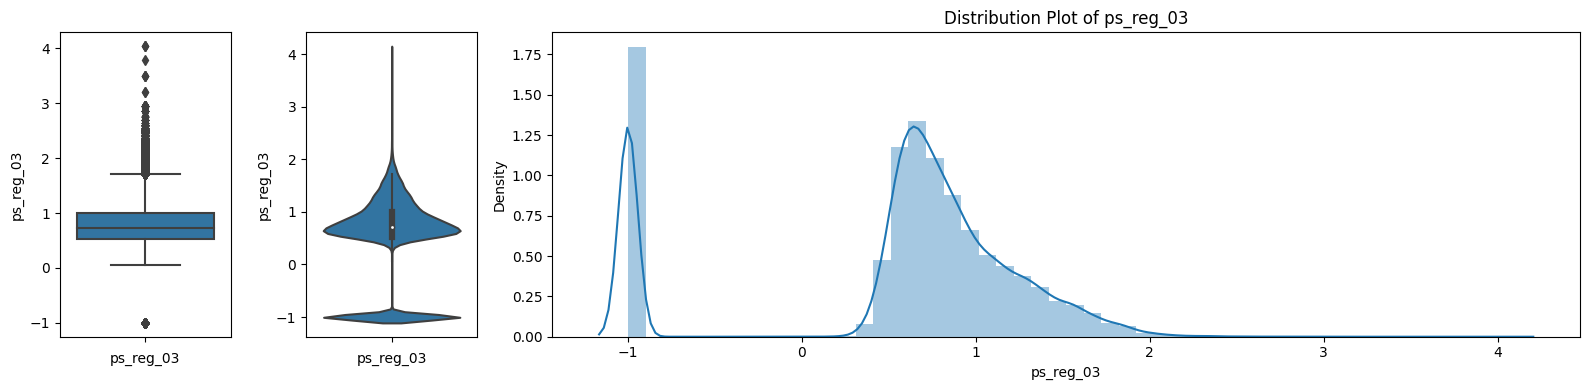

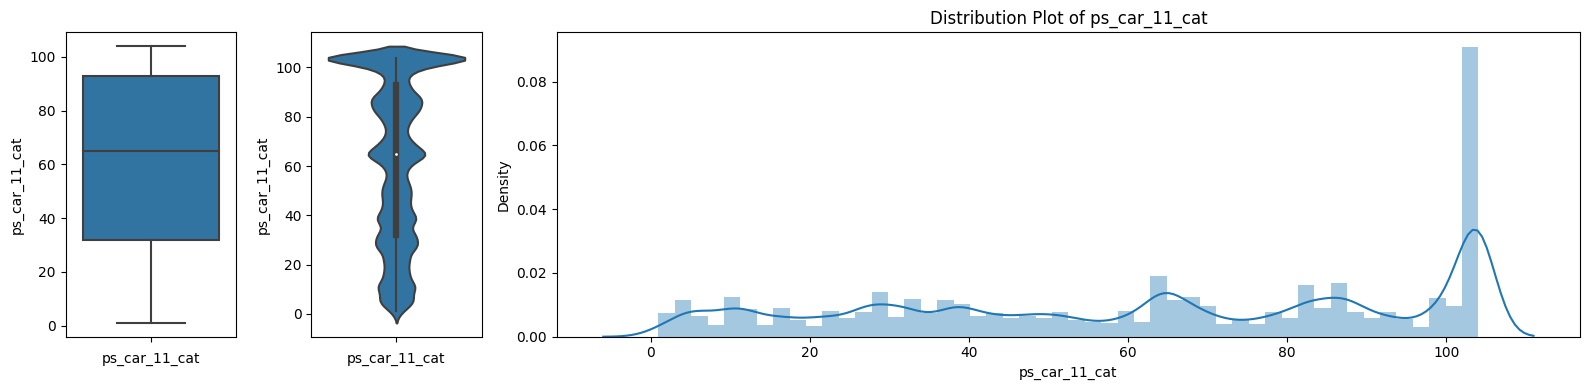

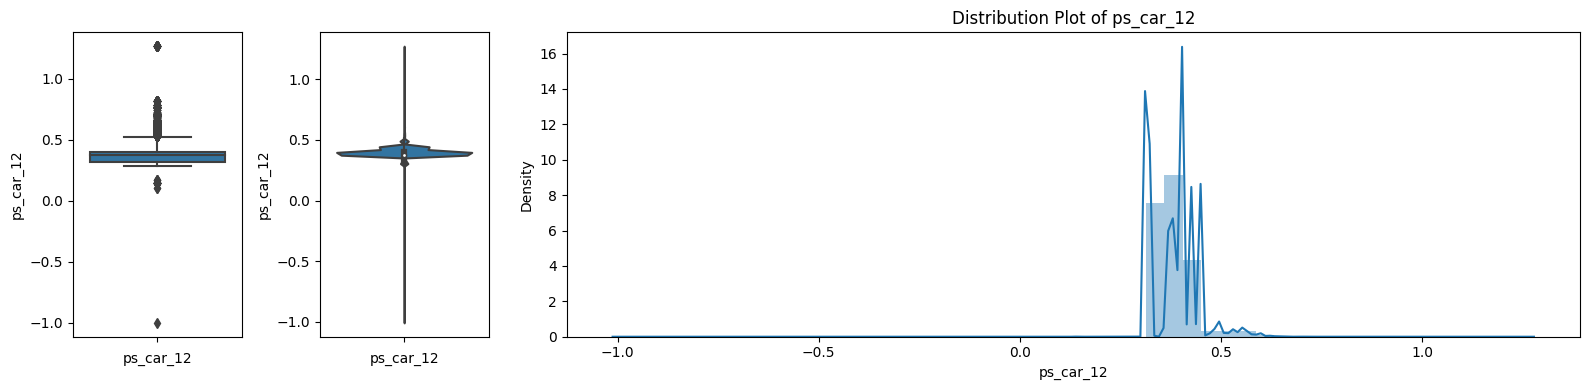

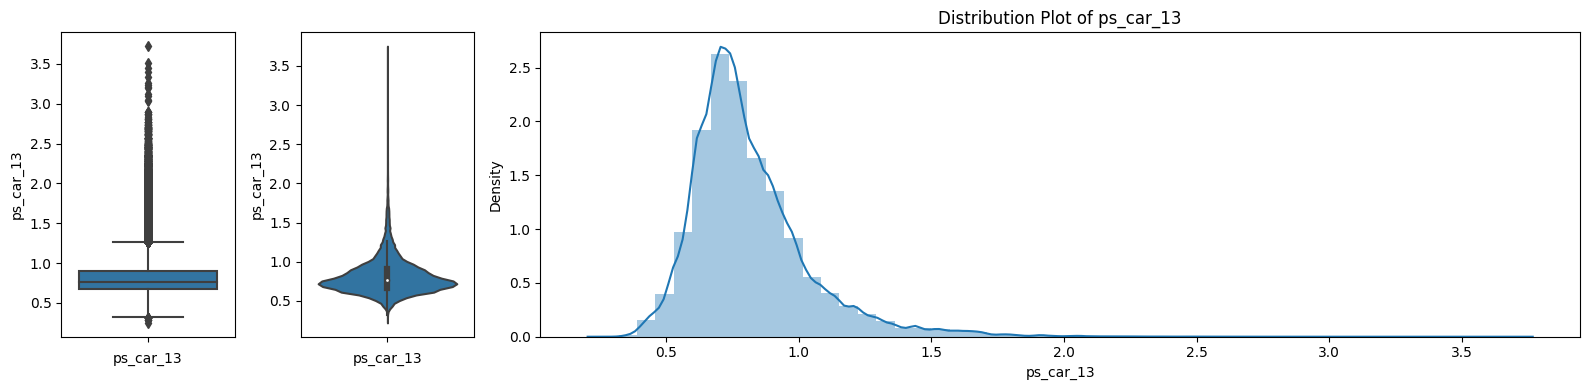

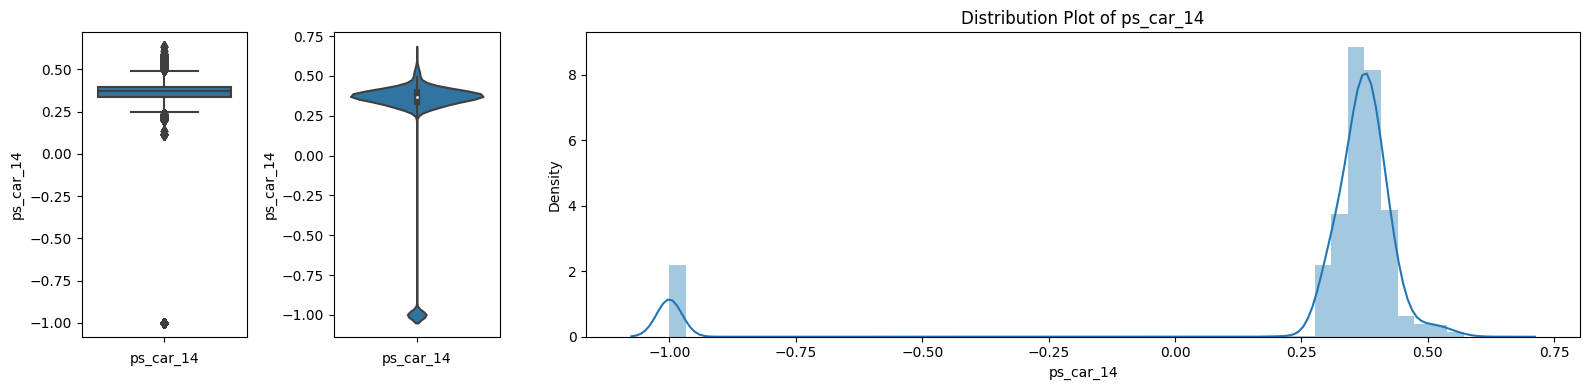

In [21]:
plot_numerical_features(train[numerical_features[1:]])

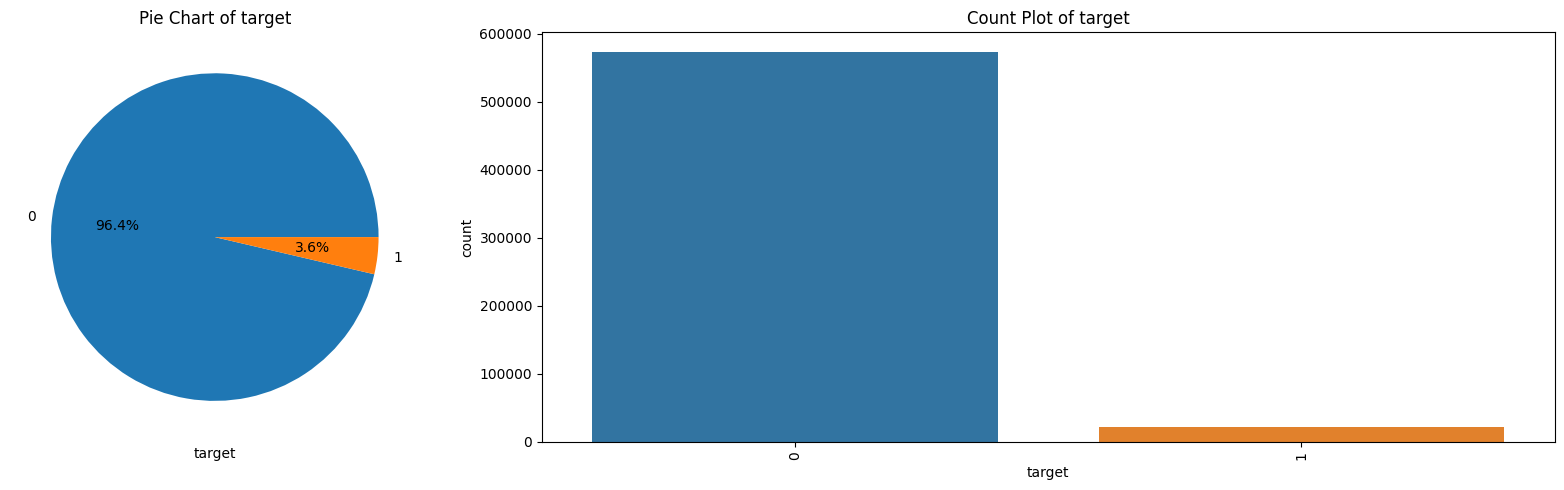

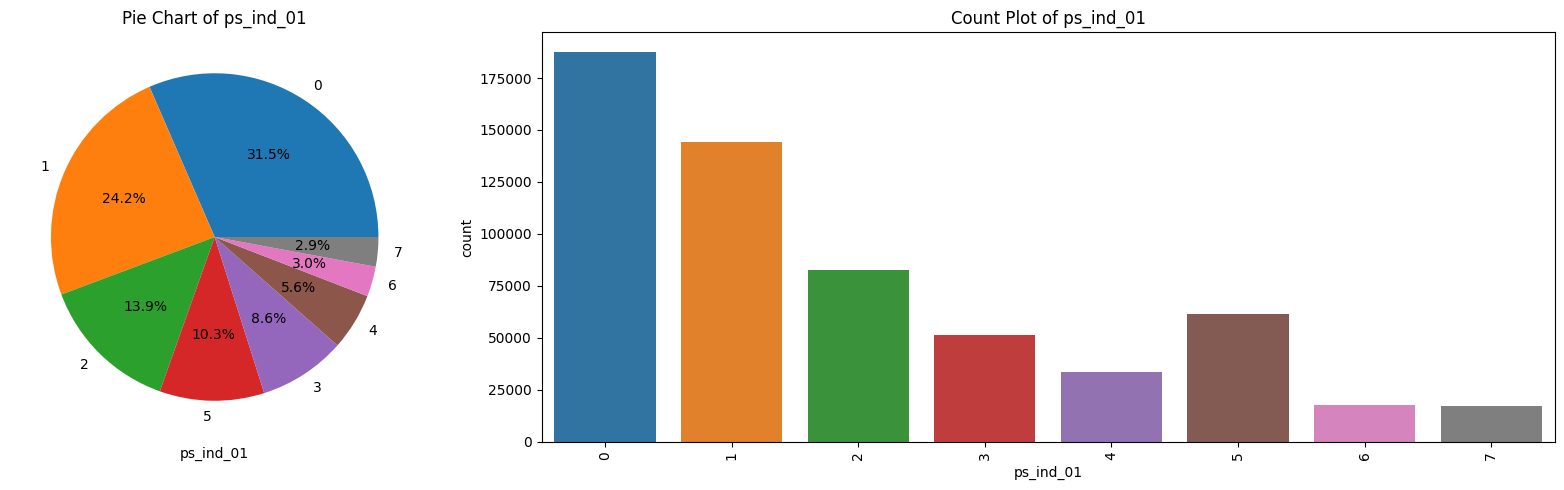

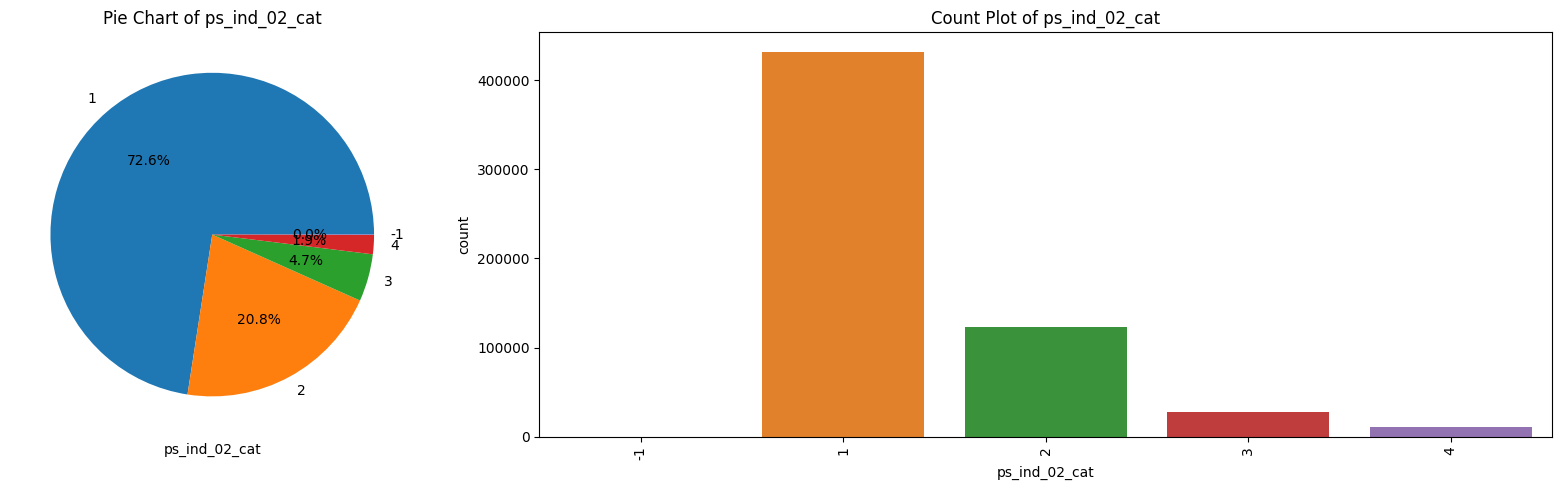

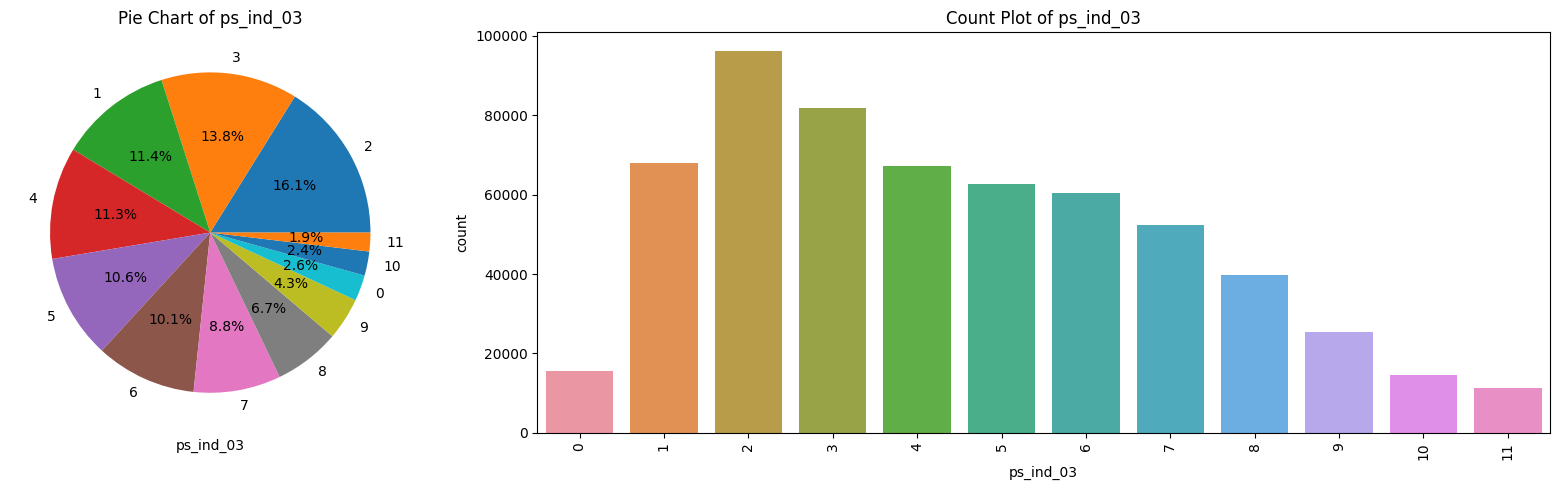

In [22]:
plot_categorical_features(train[categorical_features[:4]])

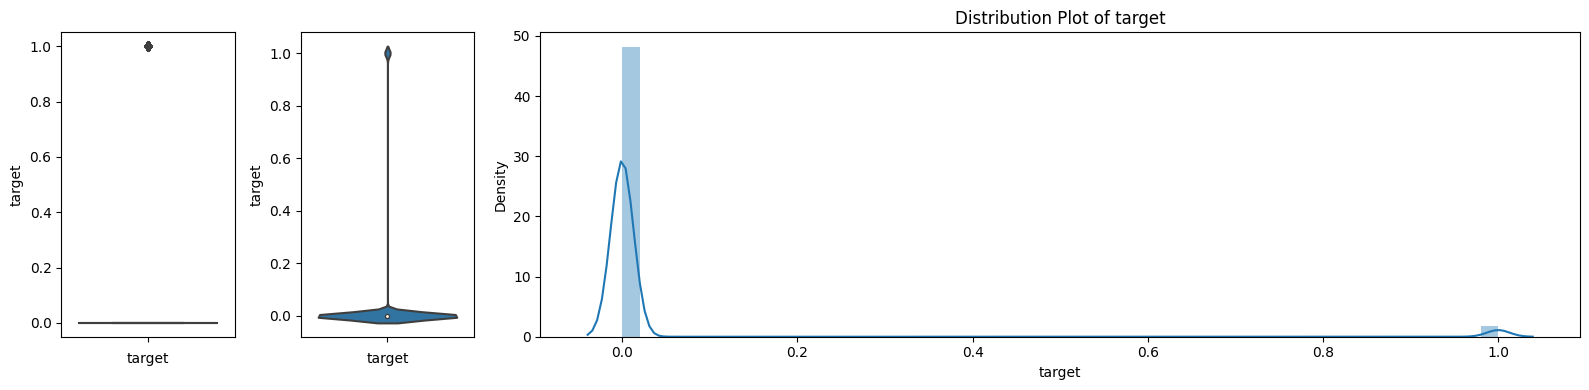

In [23]:
plot_numerical_features(train[target_feature])

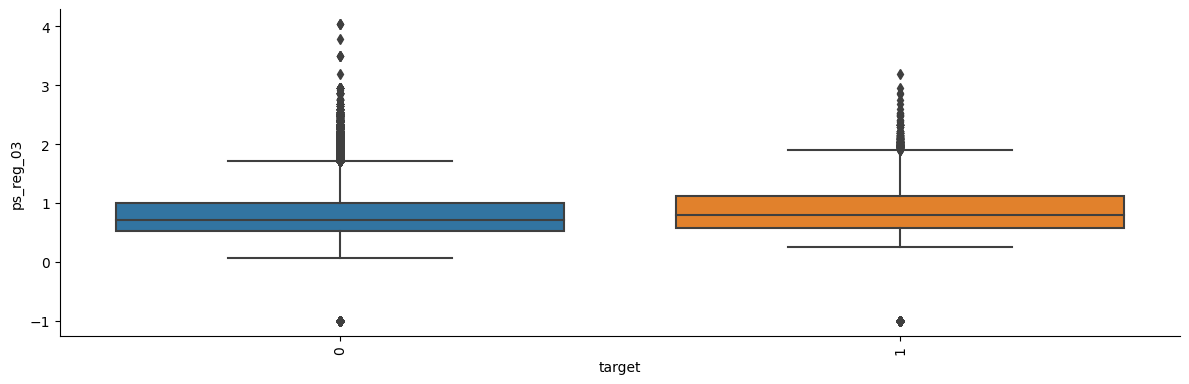

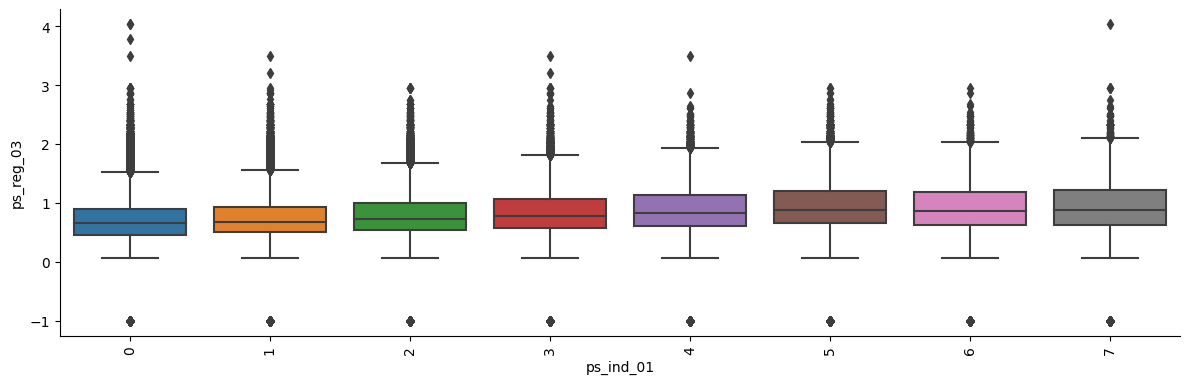

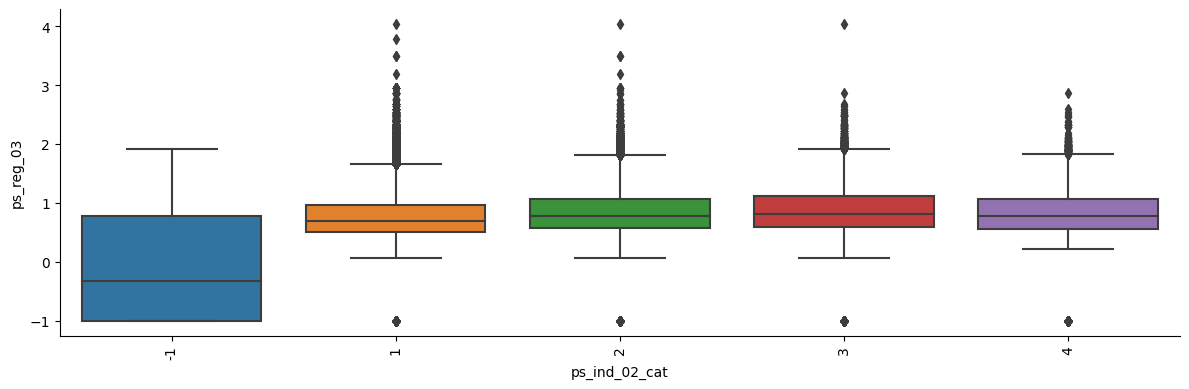

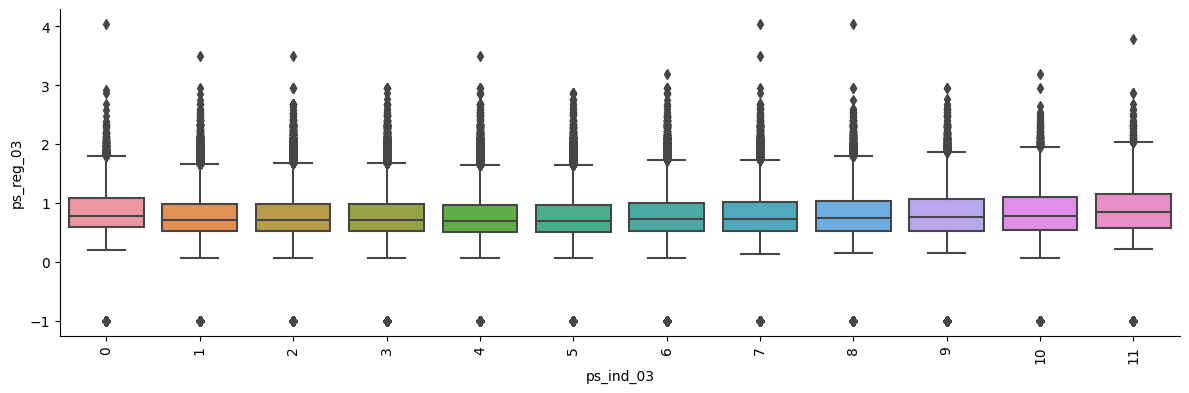

In [24]:
for cat_feature in categorical_features[:4]:
    sns.catplot(data=train, x=cat_feature, y=numerical_features[1], kind='box', height=4, aspect=3)
    plt.xticks(rotation=90)
    plt.show()

In [25]:
def plot_features_correlation(df, features, target_feature, plot_kinds, step=6, height=3, aspect=1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(features), step):
        for plot_kind in plot_kinds:
            x_vars = features[i:i + step]
            y_vars = [target_feature]
            sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, kind=plot_kind, height=height, aspect=aspect)